# Part 1: Traditional ML skills

In [2]:
# Import the basic lib to handle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Import the necessary sklearn libs to scaler and Encode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
# Load data and perform a quick inspection
df = pd.read_csv("train.csv")
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148531 entries, 0 to 148530
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               148531 non-null  int64  
 1   CustomerId       148531 non-null  int64  
 2   Surname          148531 non-null  object 
 3   CreditScore      148531 non-null  int64  
 4   Geography        148531 non-null  object 
 5   Gender           148531 non-null  object 
 6   Age              148531 non-null  float64
 7   Tenure           148531 non-null  int64  
 8   Balance          148531 non-null  float64
 9   NumOfProducts    148531 non-null  int64  
 10  HasCrCard        148531 non-null  float64
 11  IsActiveMember   148531 non-null  float64
 12  EstimatedSalary  148531 non-null  float64
 13  Churn            148531 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 15.9+ MB


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,94224,15748608,Gordon,619,Germany,Female,32.0,8,175406.13,1,1.0,0.0,172792.43,1
1,148424,15651450,Chu,676,Germany,Female,40.0,4,180520.41,2,1.0,1.0,171045.25,0
2,10745,15588560,Scott,748,France,Female,39.0,8,0.00,1,0.0,0.0,57323.18,1
3,30133,15683363,Goddard,641,France,Female,39.0,4,0.00,1,1.0,0.0,45309.24,1
4,138709,15790594,Tien,688,Germany,Male,42.0,9,161588.89,2,0.0,1.0,54019.93,0


We know that the id, CustomerId and Surname are identifiers so we can remove them , in addition the Column Gender is a dommy variable and finally the Goegraphy the have to normalize it.


In [4]:
# Drop the identifiers columns
df = df.drop(columns=['CustomerId', 'id', 'Surname'])

Let's see if there is any kind of relationship or pattern of the other variables on our variable to predict.

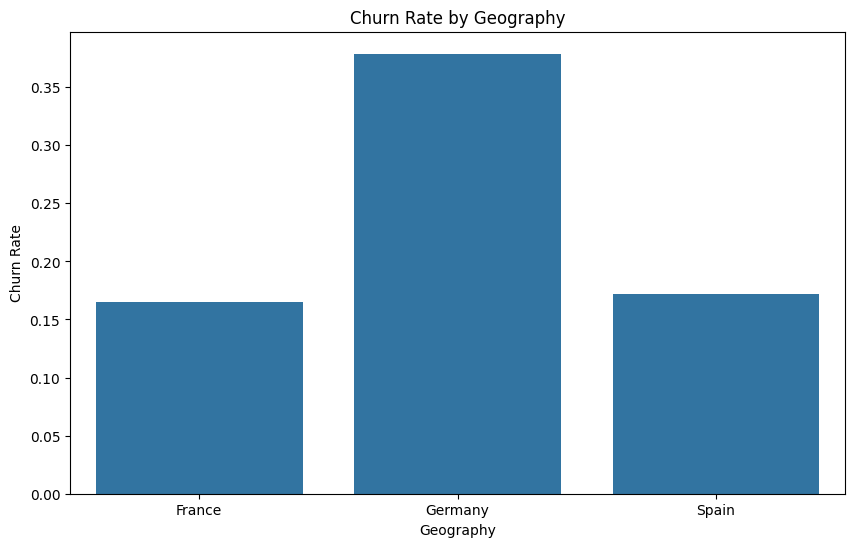

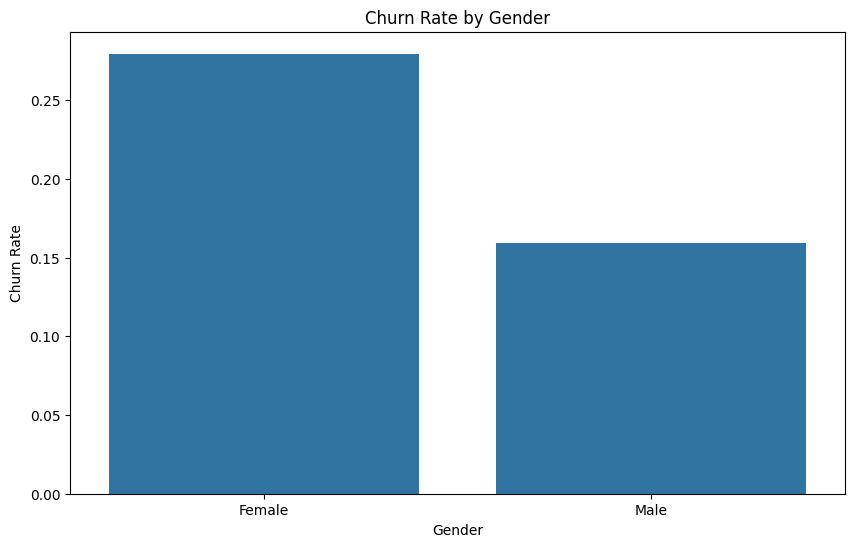

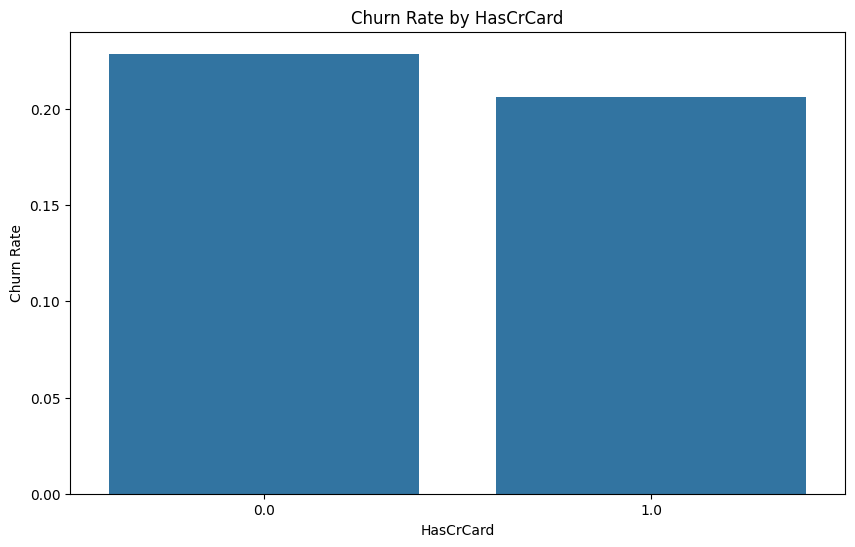

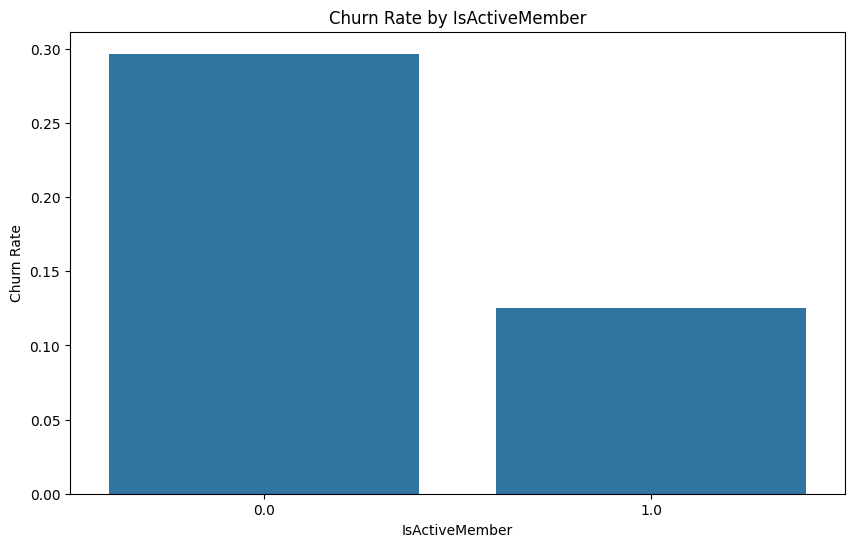

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_churn_category(data, category):
    if category not in data.columns:
        raise ValueError(f"Category '{category}' not found in the dataset.")
    grouped_data = data.groupby(category)['Churn'].mean()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grouped_data.index, y=grouped_data.values)
    plt.title(f'Churn Rate by {category}')
    plt.ylabel('Churn Rate')
    plt.xlabel(category)
    plt.show()
    
plot_churn_category(df, 'Geography')
plot_churn_category(df, 'Gender')
plot_churn_category(df, 'HasCrCard')
plot_churn_category(df, 'IsActiveMember')


we can see that germany, female and the active member have a tendency of a high churn rate, now let see a correlation matrix of Numerical column

In [6]:
# LabelEncoder  for Gender 0 women - 1 men
labelencoder_gender = LabelEncoder()
df['Gender'] = labelencoder_gender.fit_transform(df['Gender'])

# OneHotEncoder for Geography 
onehotencoder_geo = OneHotEncoder(sparse_output=False)
df1 = onehotencoder_geo.fit_transform(df[['Geography']])
df2 = pd.DataFrame(df1, columns=onehotencoder_geo.get_feature_names_out(['Geography']))
df=df.drop(columns=['Geography'])
df = pd.concat([df2,df], axis=1)

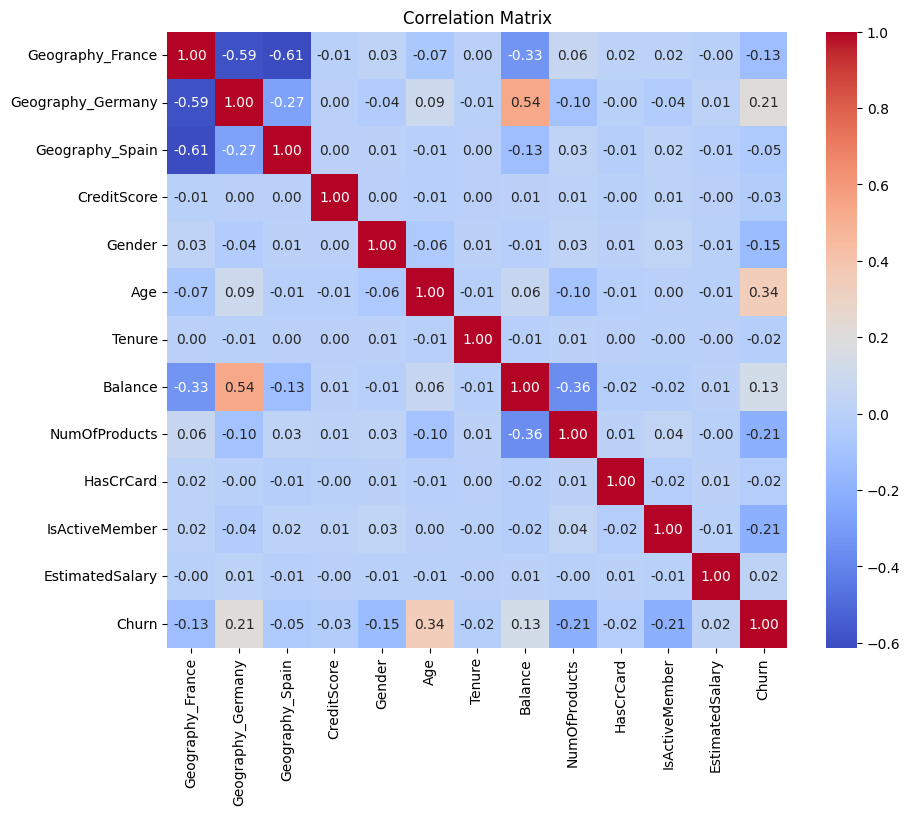

In [7]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Summary
* Now its clear that people in Germany have a clear tendency of a high Churn
* Age is another __main__ fact of Churn
* If is an active member, the number of products or Gender doesn't have a strong relation with Churn rate , but isn't low enought to dont use them

We are going to train our model firts with all the variables and then romoving the low correlation variables


In [8]:
# Split the dataset
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [9]:
# Training with Entropy
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [10]:
# Making predict of the test
y_pred = classifier.predict(X_test)

Now lets evaluate our model with the __Confusion Matrix__

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[27797  1540]
 [ 3892  3904]]


0.8537150243718525

We got a 0.85 of accuracy, lets try the same model removing the low relevance variables,but now we are going to keep those variables , now lets fine tuning our hyper-parameters

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the classifier
classifier = RandomForestClassifier(random_state=0)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=2, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
best_classifier = grid_search.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.8625199692966632


In [13]:
# Making predict of the test
y_pred = best_classifier.predict(X_test)

In [14]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[28100  1237]
 [ 3777  4019]]


0.8649718579161393

### Save the best_classifier and load

In [15]:
from joblib import dump, load
dump(best_classifier, 'best_classifier.joblib')
best_classifier_loaded = load('best_classifier.joblib')

We can see that the accuracy score has improved slightly. If we have enough time, we could experiment with a larger param_grid or try different classifiers models. For now, let’s proceed with the __best_classifier__ for inference."

In [16]:
inference = pd.read_csv('inference.csv')

Lets prepare the inference data

In [17]:
# Drop the identifiers columns
inference = inference.drop(columns=['CustomerId', 'id', 'Surname'])

In [18]:
# LabelEncoder  for Gender 0 women - 1 men
inference['Gender'] = labelencoder_gender.fit_transform(inference['Gender'])
# OneHotEncoder for Geography 
df1 = onehotencoder_geo.fit_transform(inference[['Geography']])
df2 = pd.DataFrame(df1, columns=onehotencoder_geo.get_feature_names_out(['Geography']))
inference=inference.drop(columns=['Geography'])
inference = pd.concat([df2,inference], axis=1)

Make the prediction for inference

In [19]:
X = inference.iloc[:].values
Y = best_classifier_loaded.predict(X)

### Conclusion
* The RandomForestClassifier is one of the best and fastest methods for this task, but for the future we can try all the methods and select the best one
* The code can be adapted to OOP, creaction a main class to avoid repeat the cleaning  for the inference, and a class for the prediction

In [25]:
inference["Churn"]=Y

In [26]:
inference

,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,0.0,1.0,0.0,705,0,36.0,4,154206.07,1,1.0,1.0,160162.42,0
1,1.0,0.0,0.0,686,0,43.0,8,105419.73,1,1.0,0.0,35356.46,0
2,0.0,1.0,0.0,613,1,25.0,2,134260.36,2,1.0,0.0,101382.86,0
3,1.0,0.0,0.0,581,1,44.0,2,0.00,1,1.0,1.0,107640.25,0
4,1.0,0.0,0.0,684,1,25.0,8,0.00,1,1.0,1.0,145556.24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16498,1.0,0.0,0.0,738,1,32.0,7,0.00,2,1.0,1.0,142680.92,0
16499,0.0,0.0,1.0,633,1,45.0,9,124365.44,1,0.0,0.0,83090.68,0
16500,0.0,1.0,0.0,637,1,46.0,3,120530.34,2,1.0,0.0,166586.99,0
16501,1.0,0.0,0.0,577,1,29.0,8,0.00,2,1.0,1.0,126475.79,0


### Save the CSV file with the new column

In [27]:
inference.to_csv('inference.csv', index=False)